In [ ]:
#@title Import et fonctions utile
from google.colab import files
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Function to plot the accuracies
def plot_accuracies(n_estimator_list, accuracies_train, accuracies_val, title, xlabel, ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(n_estimator_list, accuracies_train, label='Training Accuracy')
    plt.plot(n_estimator_list, accuracies_val, label='Validation Accuracy')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

## A.  Base des données

In [ ]:
uploaded = files.upload()

Saving beer_quality.csv to beer_quality (1).csv


In [ ]:
df = pd.read_csv("beer_quality.csv", sep=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
X = df.iloc[:, 0:11]
y = df.iloc[:, 11]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
print(y_train.shape)
y_test.shape

(1119,)


(480,)

In [ ]:
print(np.unique(y_train, return_counts=True))
np.unique(y_test, return_counts=True)

(array([3, 4, 5, 6, 7, 8]), array([  9,  36, 486, 438, 138,  12]))


(array([3, 4, 5, 6, 7, 8]), array([  1,  17, 195, 200,  61,   6]))

## B. Classification binaire

#### 1)	Créer une nouvelle variable quantitative ybin à deux modalités
-	0 : mauvaise qualité : y < m
-	1 : bonne qualité : y  >= m
en fonction de la médiane m de la variable y. Dans cette partie, c’est ybin qu’on cherchera à prédire.


In [ ]:
y_train_med = np.median(y_train)
y_train_bin = (y_train >= y_train_med).astype(int)
y_test_bin = (y_test >= y_train_med).astype(int)

print(np.unique(y_train_bin, return_counts=True))
np.unique(y_test_bin, return_counts=True)

(array([0, 1]), array([531, 588]))


(array([0, 1]), array([213, 267]))

#### 2)	Optimiser rapidement un arbre de décision avec random search.

In [ ]:
#@title Random search - entrainement du modèle
# Setting up the parameter distribution for random search
param_dist = {
    'max_depth': [3, 10, 50, 100, 500],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Crée l'arbre de décision
clf = DecisionTreeClassifier(random_state=0)

# Random search with cross-validation
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)

# Fitting the model
random_search.fit(X_train, y_train_bin)

In [ ]:
# Best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_
best_model = random_search.best_estimator_
best_model

DecisionTreeClassifier(max_depth=500, min_samples_leaf=2, random_state=0)

In [ ]:
best_ind = np.argmin(random_search.cv_results_["rank_test_score"])
fit_time = random_search.cv_results_["mean_fit_time"][best_ind]
score_time = random_search.cv_results_["mean_score_time"][best_ind]
print(f"Fit time of the best estimator = {fit_time} s")
print(f"Score time of the best estimator = {score_time} s")

Fit time of the best estimator = 0.008009624481201173 s
Score time of the best estimator = 0.001950836181640625 s


In [ ]:
best_score

0.743549807815503

#### 3)	Entraîner un ensemble d’arbres de décision « faibles » avec AdaBoost.

In [ ]:
#@title Entrainement des modèles
param = {'n_estimators': np.arange(1, 502, 50)}

weak_tree_maxdepth1 = DecisionTreeClassifier(max_depth=1, random_state=0) # weak tree 1
adaboost_maxdepth1 = AdaBoostClassifier(estimator=weak_tree_maxdepth1, random_state=42) # Définir le modèle AdaBoost

grid1 = GridSearchCV(adaboost_maxdepth1, param, n_jobs=-1, return_train_score=True, cv=5) # cross validation sur 5 fold et trouver le meilleur estimateur sur l'espace de recherche
grid1.fit(X_train, y_train_bin)

# récupérer la liste des accuracy en apprentissage et validation
accuracies_depth1_train = grid1.cv_results_["mean_train_score"]
accuracies_depth1_val =  grid1.cv_results_["mean_test_score"]

weak_tree_maxdepth5 = DecisionTreeClassifier(max_depth=5, random_state=0) # weak tree 1
adaboost_maxdepth5 = AdaBoostClassifier(estimator=weak_tree_maxdepth5, random_state=42) # Définir le modèle AdaBoost

grid2 = GridSearchCV(adaboost_maxdepth5, param, n_jobs=-1, return_train_score=True, cv=5) # cross validation sur 5 fold et trouver le meilleur estimateur sur l'espace de recherche
grid2.fit(X_train, y_train_bin)

# récupérer la liste des accuracy en apprentissage et validation
accuracies_depth5_train = grid2.cv_results_["mean_train_score"]
accuracies_depth5_val =  grid2.cv_results_["mean_test_score"]

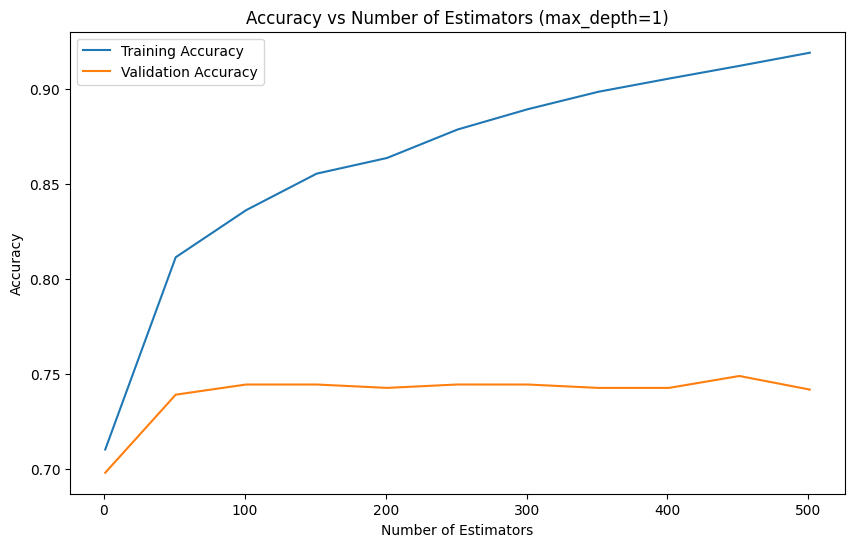

In [ ]:
# Plot for max_depth = 1
plot_accuracies(
    param["n_estimators"],
    accuracies_depth1_train,
    accuracies_depth1_val,
    "Accuracy vs Number of Estimators (max_depth=1)",
    "Number of Estimators",
    "Accuracy"
)

In [ ]:
grid1.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=0),
                   n_estimators=451, random_state=42)

In [ ]:
grid1.best_score_

0.7489309737347853

In [ ]:
best_estimator_indice1 = np.where(grid1.cv_results_["rank_test_score"] == 1)
fit_time1 = grid1.cv_results_["mean_fit_time"][best_estimator_indice1][0]
score_time1 = grid1.cv_results_["mean_score_time"][best_estimator_indice1][0]
print(f"Fit time of the best estimator = {fit_time1} s")
print(f"Score time of the best estimator = {score_time1} s")

Fit time of the best estimator = 2.1857913017272947 s
Score time of the best estimator = 0.18169898986816407 s


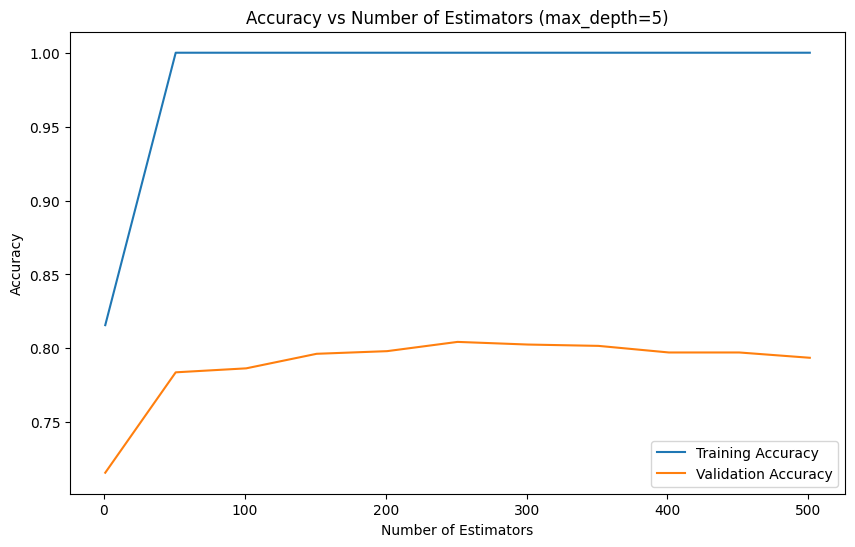

In [ ]:
# Plot for max_depth = 5
plot_accuracies(
    param["n_estimators"],
    accuracies_depth5_train,
    accuracies_depth5_val,
    "Accuracy vs Number of Estimators (max_depth=5)",
    "Number of Estimators",
    "Accuracy"
)

In [ ]:
grid2.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    random_state=0),
                   n_estimators=251, random_state=42)

In [ ]:
print(grid2.best_score_)
grid2.best_estimator_.score(X_test, y_test_bin)

0.8043561819346573


0.8041666666666667

In [ ]:
best_estimator_indice2 = np.where(grid2.cv_results_["rank_test_score"] == 1)
fit_time2 = grid2.cv_results_["mean_fit_time"][best_estimator_indice2][0]
score_time2 = grid2.cv_results_["mean_score_time"][best_estimator_indice2][0]
print(f"Fit time of the best estimator = {fit_time2} s")
print(f"Score time of the best estimator = {score_time2} s")

Fit time of the best estimator = 2.1989768505096436 s
Score time of the best estimator = 0.09432735443115234 s


###### importance des caractéristique dans la décision d'AdaBoost

In [ ]:
feature_importances = grid2.best_estimator_.feature_importances_
features = grid2.best_estimator_.feature_names_in_

features_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Trier les caractéristiques par importances
features_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
4,chlorides,0.121923
7,density,0.113225
6,total sulfur dioxide,0.095579
8,pH,0.094291
9,sulphates,0.091115
1,volatile acidity,0.088420
2,citric acid,0.085949
0,fixed acidity,0.079346
5,free sulfur dioxide,0.078660
3,residual sugar,0.076924


## C.  Classification multiclasse

### 1)	Créer une nouvelle variable quantitative ymulti discrète à 3 modalités : qualité basse (0), moyenne (1) ou élevée (2).

In [ ]:
def categorize_quality(quality):
    if quality <= 4:
        return 0  # Qualité basse
    elif quality <= 6:
        return 1  # Qualité moyenne
    else:
        return 2  # Qualité élevée

ymulti_train = y_train.apply(categorize_quality)
ymulti_test = y_test.apply(categorize_quality)

2)	Déterminer les effectifs des différentes classes. Si nécessaire, équilibrer les données d’apprentissage par sous-échantillonnage ou augmentation de données (SMOTE). Dans la suite, on présentera les résultats obtenus avec et sans équilibrage.

In [ ]:
print(np.unique(ymulti_train, return_counts=True))
np.unique(ymulti_test, return_counts=True)

(array([0, 1, 2]), array([ 45, 924, 150]))


(array([0, 1, 2]), array([ 18, 395,  67]))

In [ ]:
# Equilibrage par augmentation de données (SMOTE)
smote = SMOTE(random_state=42)
X_train_smote, ymulti_train_smote = smote.fit_resample(X_train, ymulti_train)
np.unique(ymulti_train_smote, return_counts=True)

(array([0, 1, 2]), array([924, 924, 924]))

### Partie 1

#### 3)	Entraîner un réseau de neurones à une couche cachée avec early stopping.

In [ ]:
#@title Entrainement des modèle avec early stopping

param_dist2 = {'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (250,), (300,)],
               'alpha': [0.0001, 0.001, 0.01, 0.1],
               'learning_rate_init': [0.001, 0.01, 0.1]}

mlp = MLPClassifier(random_state=1, early_stopping=True)

random_search_mlp1 = RandomizedSearchCV(mlp, param_distributions=param_dist2, n_iter=10, cv=5, random_state=42, return_train_score=True)
random_search_mlp2 = RandomizedSearchCV(mlp, param_distributions=param_dist2, n_iter=10, cv=5, random_state=42, return_train_score=True)

random_search_mlp1.fit(X_train_smote, ymulti_train_smote) # données équilibrées
random_search_mlp2.fit(X_train, ymulti_train) # données désquilibrées

# Best parameters and score
# données équilibrées
best_score_mlp1 = random_search_mlp1.best_score_
best_model_mlp1 = random_search_mlp1.best_estimator_
# données désquilibrées
best_model_mlp2 = random_search_mlp2.best_estimator_
best_score_mlp2 = random_search_mlp2.best_score_

In [ ]:
best_model_mlp1

MLPClassifier(early_stopping=True, hidden_layer_sizes=(200,),
              learning_rate_init=0.01, random_state=1)

In [ ]:
best_model_mlp2

MLPClassifier(early_stopping=True, learning_rate_init=0.01, random_state=1)

In [ ]:
print(best_score_mlp1)
best_model_mlp1.score(X_test, ymulti_test)

0.7640732429180083


0.5104166666666666

In [ ]:
print(best_score_mlp2)
best_model_mlp2.score(X_test, ymulti_test)

0.8275224215246636


0.8229166666666666

In [ ]:
#@title calcul des matrices de confusion

# Evaluation sur le jeu de test
ymulti_smote_pred = best_model_mlp1.predict(X_test)
ymulti_pred = best_model_mlp2.predict(X_test)

# Afficher la matrice de confusion sur l'ensemble de test
cm1 = confusion_matrix(ymulti_test, ymulti_smote_pred)
cm2 = confusion_matrix(ymulti_test, ymulti_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=best_model_mlp1.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=best_model_mlp2.classes_)

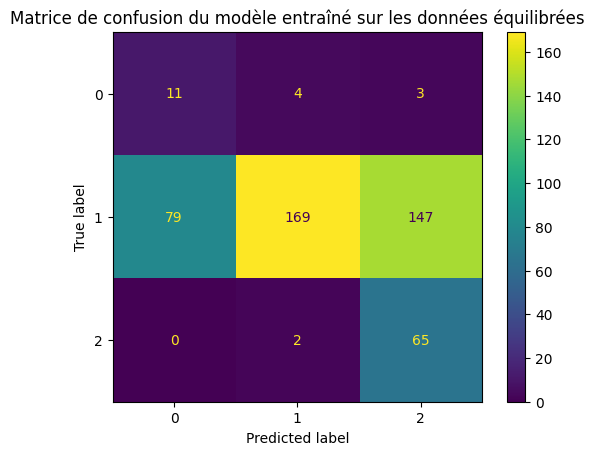

              precision    recall  f1-score   support

           0       0.12      0.61      0.20        18
           1       0.97      0.43      0.59       395
           2       0.30      0.97      0.46        67

    accuracy                           0.51       480
   macro avg       0.46      0.67      0.42       480
weighted avg       0.84      0.51      0.56       480



In [ ]:
disp1.plot()
plt.title('Matrice de confusion du modèle entraîné sur les données équilibrées')
plt.show()

# Rapport de classification
print(classification_report(ymulti_test, ymulti_smote_pred))

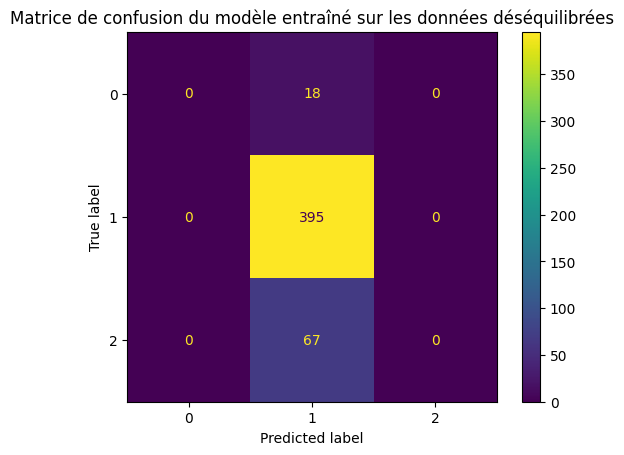

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.82      1.00      0.90       395
           2       0.00      0.00      0.00        67

    accuracy                           0.82       480
   macro avg       0.27      0.33      0.30       480
weighted avg       0.68      0.82      0.74       480



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
disp2.plot()
plt.title('Matrice de confusion du modèle entraîné sur les données déséquilibrées')
plt.show()

# Rapport de classification
print(classification_report(ymulti_test, ymulti_pred))

#### 4)	Faire un bagging en utilisant comme classifieur de base le réseau de neurones.

In [ ]:
#@title Entrainement du bagging

n_estimators_range = np.arange(20, 151, 20)
train_accuracies_smote = []
validation_accuracies_smote = []

for n_estimators in n_estimators_range:
    bagging = BaggingClassifier(estimator=best_model_mlp1, n_estimators=n_estimators, n_jobs=-1, random_state=42, oob_score=True)
    bagging.fit(X_train_smote, ymulti_train_smote)

    # Évaluation sur l'ensemble d'apprentissage
    train_accuracies_smote.append(bagging.score(X_train_smote, ymulti_train_smote))
    # Évaluation sur l'ensemble de validation
    validation_accuracies_smote.append(bagging.oob_score_)

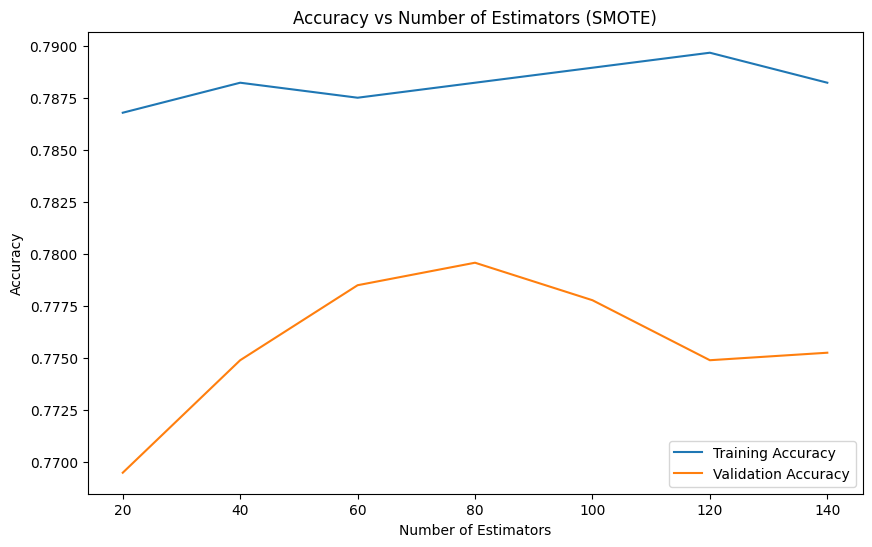

In [ ]:
plot_accuracies(
    n_estimators_range,
    train_accuracies_smote,
    validation_accuracies_smote,
    "Accuracy vs Number of Estimators (SMOTE)",
    "Number of Estimators",
    "Accuracy"
)

In [ ]:
n_estimator_best = n_estimators_range[np.argmax(validation_accuracies_smote)]
optimal_bag = BaggingClassifier(estimator=best_model_mlp1, n_estimators=n_estimator_best, n_jobs=-1, random_state=42, oob_score=True)
start_time = time.time()
optimal_bag.fit(X_train_smote, ymulti_train_smote)
end_time = time.time()
fit_time = end_time - start_time
print(f"Fit time: {fit_time:.4f} seconds")

Fit time: 49.2902 seconds


In [ ]:
optimal_bag

BaggingClassifier(estimator=MLPClassifier(early_stopping=True,
                                          hidden_layer_sizes=(200,),
                                          learning_rate_init=0.01,
                                          random_state=1),
                  n_estimators=80, n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
start_time = time.time()
optimal_bag.predict(X_test)
end_time = time.time()
score_time = end_time - start_time
print(f"Score time: {score_time:.4f} seconds")

Score time: 0.1946 seconds


In [ ]:
print(optimal_bag.oob_score_)
optimal_bag.score(X_test, ymulti_test)

0.7795815295815296


0.6395833333333333

### Partie 2

#### 5)	Entraîner une forêt aléatoire

-	Tracer la courbe accuracy en fonction de n_estimators pour max_depth = None, en apprentissage et en test.

In [ ]:
#@title Entrainement du random forest pour max_depth = None

n_estimators_range = np.arange(20, 151, 20)
train_accuracies_rf_smote = []
validation_accuracies_rf_smote = []

train_accuracies_rf = []
validation_accuracies_rf = []

for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=None, random_state=42, n_jobs=-1, oob_score=True)
    # Entrainement et accuracy sur les données équilibrées
    rf.fit(X_train_smote, ymulti_train_smote)
    train_accuracies_rf_smote.append(rf.score(X_train_smote, ymulti_train_smote))
    validation_accuracies_rf_smote.append(rf.oob_score_)
    # Entrainement et accuracy sur les données déséquilibrées
    rf.fit(X_train, ymulti_train)
    train_accuracies_rf.append(rf.score(X_train, ymulti_train))
    validation_accuracies_rf.append(rf.oob_score_)

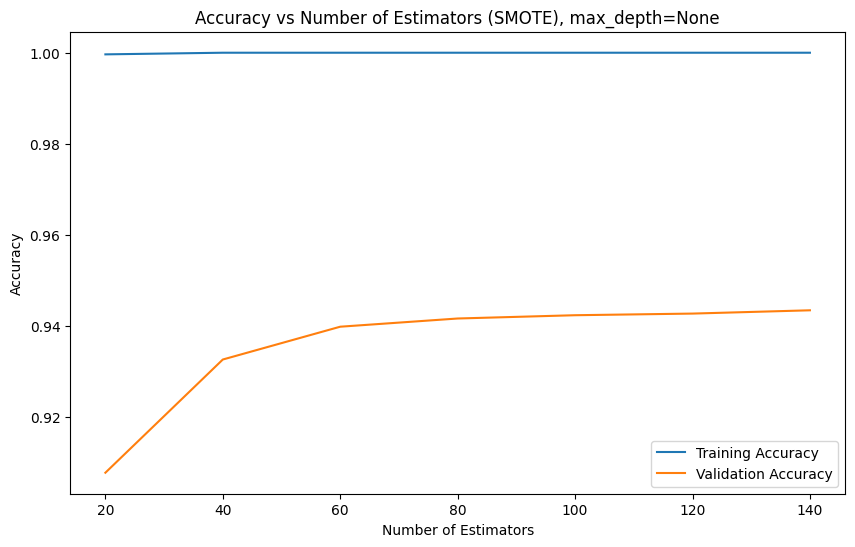

In [ ]:
plot_accuracies(
    n_estimators_range,
    train_accuracies_rf_smote,
    validation_accuracies_rf_smote,
    "Accuracy vs Number of Estimators (SMOTE), max_depth=None",
    "Number of Estimators",
    "Accuracy"
)

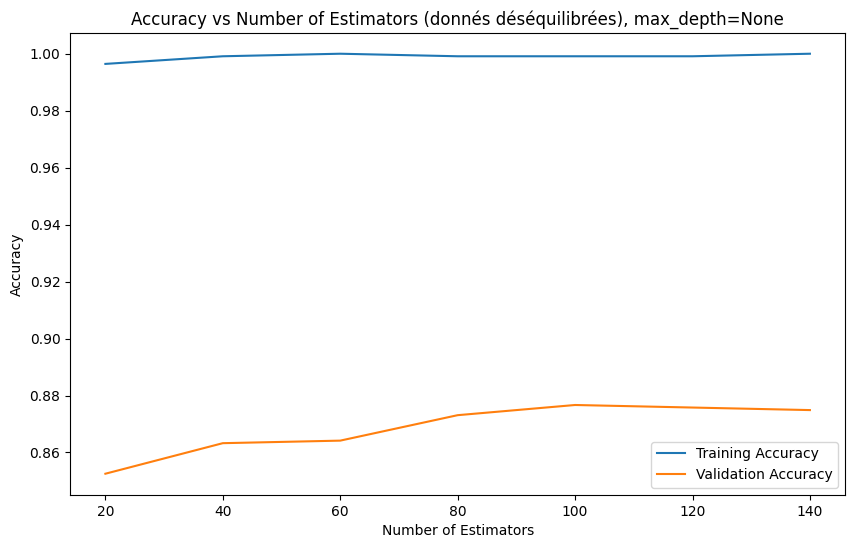

In [ ]:
plot_accuracies(
    n_estimators_range,
    train_accuracies_rf,
    validation_accuracies_rf,
    "Accuracy vs Number of Estimators (donnés déséquilibrées), max_depth=None",
    "Number of Estimators",
    "Accuracy"
)

-	Faire une recherche aléatoire (random search) pour optimiser les paramètres max_depth et n_estimators. Choisir les paramètres optimaux et donner les performances en apprentissage et en test.

In [ ]:
#@title Random search - entrainement du modèle.

param_dist3 = {'n_estimators': np.arange(20, 151, 20),
               'max_depth': [30, 100, 300]} # Tester uniquement des grandes profondeurs (Intêret du bagging)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search_rf1 = RandomizedSearchCV(rf, param_distributions=param_dist3, n_iter=10, cv=5, random_state=42, return_train_score=True)
random_search_rf1.fit(X_train_smote, ymulti_train_smote)

random_search_rf2 = RandomizedSearchCV(rf, param_distributions=param_dist3, n_iter=10, cv=5, random_state=42, return_train_score=True)
random_search_rf2.fit(X_train, ymulti_train)

# Best parameters and score
# données équilibrées
best_score_rf1 = random_search_rf1.best_score_
best_model_rf1 = random_search_rf1.best_estimator_
# données désquilibrées
best_model_rf2 = random_search_rf2.best_estimator_
best_score_rf2 = random_search_rf2.best_score_

In [ ]:
best_model_rf1

RandomForestClassifier(max_depth=300, n_estimators=80, n_jobs=-1,
                       random_state=42)

In [ ]:
best_model_rf2

RandomForestClassifier(max_depth=300, n_estimators=80, n_jobs=-1,
                       random_state=42)

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=300, random_state=42)
val_score = np.mean(cross_val_score(base_estimator, X_train_smote, ymulti_train_smote, cv=5, n_jobs=-1))
val_score

0.8719348229095522

In [ ]:
val_score2 = np.mean(cross_val_score(base_estimator, X_train, ymulti_train, cv=5, n_jobs=-1))
val_score2

0.8284192825112108

In [ ]:
print(best_model_rf1.score(X_train_smote, ymulti_train_smote))
print(best_score_rf1)
best_model_rf1.score(X_test, ymulti_test)

1.0
0.9368686375906592


0.8020833333333334

In [ ]:
print(best_model_rf2.score(X_train, ymulti_train))
print(best_score_rf2)
best_model_rf2.score(X_test, ymulti_test)

0.9991063449508489
0.8704356181934658


0.8458333333333333

In [ ]:
#@title Calcul des matrices de confusion

# Evaluation sur le jeu de test
ymulti_smote_pred = best_model_rf1.predict(X_test)
ymulti_pred = best_model_rf2.predict(X_test)

# Afficher la matrice de confusion sur l'ensemble de test
cm1 = confusion_matrix(ymulti_test, ymulti_smote_pred)
cm2 = confusion_matrix(ymulti_test, ymulti_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=best_model_rf1.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=best_model_rf2.classes_)

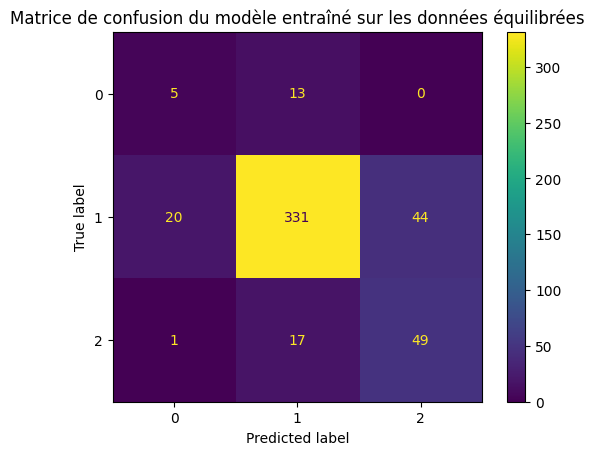

              precision    recall  f1-score   support

           0       0.19      0.28      0.23        18
           1       0.92      0.84      0.88       395
           2       0.53      0.73      0.61        67

    accuracy                           0.80       480
   macro avg       0.55      0.62      0.57       480
weighted avg       0.84      0.80      0.81       480



In [ ]:
disp1.plot()
plt.title('Matrice de confusion du modèle entraîné sur les données équilibrées')
plt.show()

# Rapport de classification
print(classification_report(ymulti_test, ymulti_smote_pred))

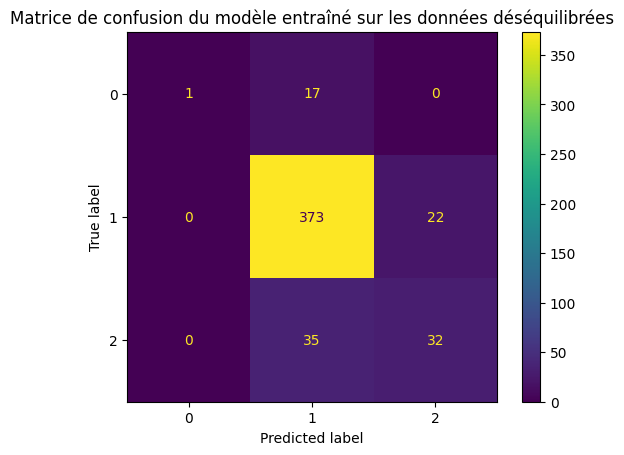

              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.88      0.94      0.91       395
           2       0.59      0.48      0.53        67

    accuracy                           0.85       480
   macro avg       0.82      0.49      0.51       480
weighted avg       0.84      0.85      0.83       480



In [ ]:
disp2.plot()
plt.title('Matrice de confusion du modèle entraîné sur les données déséquilibrées')
plt.show()

# Rapport de classification
print(classification_report(ymulti_test, ymulti_pred))

In [ ]:
best_estimator_indice1 = np.argmin(random_search_rf1.cv_results_["rank_test_score"])
fit_time1 = random_search_rf1.cv_results_["mean_fit_time"][best_estimator_indice1]
score_time1 = random_search_rf1.cv_results_["mean_score_time"][best_estimator_indice1]
print(f"Fit time of the best estimator = {fit_time1} s")
print(f"Score time of the best estimator = {score_time1} s")

Fit time of the best estimator = 0.5334407806396484 s
Score time of the best estimator = 0.03700442314147949 s


##### importance des caractéristique

In [ ]:
feature_importances = best_model_rf1.feature_importances_
features = best_model_rf1.feature_names_in_

features_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Trier les caractéristiques par importances
features_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
10,alcohol,0.181830
9,sulphates,0.140592
1,volatile acidity,0.137133
6,total sulfur dioxide,0.108473
8,pH,0.069317
2,citric acid,0.068928
5,free sulfur dioxide,0.068525
4,chlorides,0.059809
3,residual sugar,0.058453
7,density,0.056091
